In [1]:
# script to plot vertical profiles of some AWAS tracers
# include plain scatter, boxplots per KM, and sampling distribution 
# author: sofia chelpon
# created: Feb 12, 2020 

In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import datetime 
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [2]:
mypath1 = '/Volumes/scdrive2/TTS_2020/contrast_readin/awas/awas_trace_gases.nc'
awas_trc = xr.open_dataset(mypath1)
awas_trc

<xarray.Dataset>
Dimensions:                       (GGALT: 585, GGLAT: 585, GGLON: 585, Time: 585)
Coordinates:
  * Time                          (Time) datetime64[ns] 2014-01-22T00:20:25 ... 2014-02-25T07:17:05
  * GGALT                         (GGALT) float32 3846.6377 4106.623 ... 952.71
  * GGLAT                         (GGLAT) float32 13.294079 ... 13.395386
  * GGLON                         (GGLON) float32 145.20465 ... 144.60631
Data variables:
    C2H6_Ethane                   (Time) float32 ...
    C2H2_Ethyne                   (Time) float32 ...
    C3H8_Propane                  (Time) float32 ...
    C4H10_Isobutane               (Time) float32 ...
    C4H10_nButane                 (Time) float32 ...
    C5H12_nPentane                (Time) float32 ...
    C6H6_Benzene                  (Time) float32 ...
    OCS_Carbonyl_sulfide          (Time) float32 ...
    C2H6S_Dimethyl_sulfide        (Time) float32 ...
    CCl2F2_CFC_12                 (Time) float32 ...
    CCl3F_CFC_

In [3]:
# put desired toga data into a dataframe for easier chunking 
alt_bins = np.arange(0,17,1)
alt_bin_labels = np.arange(0.5, 16.5, 1)

awas_df = pd.DataFrame({"GGALT [km]": awas_trc.GGALT/1000})
awas_df['alt_bins'] = pd.cut(awas_df['GGALT [km]'], bins=alt_bins, labels=alt_bin_labels)

# add all tracers back in 
for ii in awas_trc.data_vars:
    awas_df[str(ii)] = awas_trc[ii]

# index to height bin (center of KM)
awas_df = awas_df.drop(columns="GGALT [km]")
awas_df.set_index('alt_bins')

,C2H6_Ethane,C2H2_Ethyne,C3H8_Propane,C4H10_Isobutane,C4H10_nButane,C5H12_nPentane,C6H6_Benzene,OCS_Carbonyl_sulfide,C2H6S_Dimethyl_sulfide,CCl2F2_CFC_12,...,C2Br2F4_Halon_2402,CH2BrCl_Bromochloromethane,CH2Br2_Methylene_bromide,CHBrCl2_Bromodichloromethane,CHBr2Cl_Dibromochloromethane,CHBr3_Bromoform,C2H5ONO2_Ethyl_nitrate,C3H7NO3_Isopropyl_nitrate,C4H9NO3_2_Butyl_nitrate,C4H9NO3_n_Butyl_nitrate
alt_bins,,,,,,,,,,,,,,,,,,,,,
3.5,447.0,81.0,31.0,4.0,7.1,1.3,9.700000,575.0,15.500000,517.0,...,0.43,0.11,0.96,NaN,0.32,0.77,4.20,1.94,1.11,0.00
4.5,436.0,60.0,29.0,1.9,4.3,0.1,7.200000,561.0,21.299999,519.0,...,0.42,0.13,0.98,NaN,0.38,0.76,4.36,1.78,0.91,0.00
4.5,443.0,52.0,26.0,1.9,3.7,0.5,6.900000,561.0,14.600000,525.0,...,0.43,0.14,1.04,NaN,0.52,0.80,4.08,1.80,1.07,0.00
5.5,461.0,52.0,31.0,1.9,3.2,NaN,6.600000,567.0,5.400000,523.0,...,0.43,0.16,1.01,0.67,0.43,0.89,4.35,1.84,1.05,0.00
3.5,408.0,37.0,20.0,2.3,2.2,NaN,4.200000,556.0,2.600000,516.0,...,0.40,0.12,0.98,0.65,0.23,0.66,3.98,1.63,0.59,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.5,804.0,108.0,86.0,5.0,7.2,0.2,20.299999,561.0,0.800000,519.0,...,0.41,0.23,1.00,0.19,0.13,0.58,2.06,2.68,0.97,1.91
4.5,777.0,105.0,80.0,4.6,7.2,0.4,18.799999,561.0,0.800000,520.0,...,0.41,0.18,1.00,0.29,0.14,0.51,2.10,2.55,0.95,1.78
3.5,646.0,102.0,52.0,2.8,4.4,0.2,18.799999,559.0,0.300000,531.0,...,0.41,0.20,0.88,0.28,0.13,0.45,2.26,1.96,0.78,1.15


In [4]:
##### ----- count number of measurements per km bin for each tracer 
# for sampling histogram
awas_df_count = pd.DataFrame(index = alt_bin_labels)
awas_df_count.index.name = 'bin_centers'

for ii in awas_trc.data_vars:
    count = awas_df.groupby('alt_bins')[str(ii)].count()
    awas_df_count[str(ii)] = count.tolist()
awas_df_count

,C2H6_Ethane,C2H2_Ethyne,C3H8_Propane,C4H10_Isobutane,C4H10_nButane,C5H12_nPentane,C6H6_Benzene,OCS_Carbonyl_sulfide,C2H6S_Dimethyl_sulfide,CCl2F2_CFC_12,...,C2Br2F4_Halon_2402,CH2BrCl_Bromochloromethane,CH2Br2_Methylene_bromide,CHBrCl2_Bromodichloromethane,CHBr2Cl_Dibromochloromethane,CHBr3_Bromoform,C2H5ONO2_Ethyl_nitrate,C3H7NO3_Isopropyl_nitrate,C4H9NO3_2_Butyl_nitrate,C4H9NO3_n_Butyl_nitrate
bin_centers,,,,,,,,,,,,,,,,,,,,,
0.5,36,34,36,36,36,32,34,35,36,34,...,32,34,36,33,36,35,36,36,35,36
1.5,22,22,22,22,22,17,22,22,21,22,...,18,22,22,19,22,22,22,22,22,22
2.5,16,15,16,16,16,10,15,15,14,13,...,15,16,16,13,16,16,16,16,16,16
3.5,25,25,25,25,25,17,25,24,21,24,...,24,25,25,22,25,25,25,25,25,25
4.5,33,33,33,33,33,21,33,33,25,33,...,33,33,33,30,33,33,33,33,33,33
5.5,26,26,26,26,26,14,26,26,19,24,...,24,26,26,24,26,26,26,26,26,26
6.5,17,17,17,17,17,10,15,17,12,17,...,15,16,16,16,17,17,17,17,17,17
7.5,20,20,20,20,20,12,19,20,16,14,...,20,20,20,17,20,20,20,20,20,20
8.5,18,18,18,18,18,12,18,18,15,17,...,17,17,17,16,18,18,18,18,18,18


In [5]:
# keep only counts that we want to plot 
#awas_df_count_forplot = awas_df_count.drop(columns = ['n_Butane', 'i_Butane', 'C3H8', 'Methanol', 
#                                                     'Dibromomethane', 'Chloroform'])

awas_df_count_forplot = pd.DataFrame(index = alt_bin_labels)
awas_df_count_forplot = pd.DataFrame({"DMS": awas_df_count.C2H6S_Dimethyl_sulfide, 
                                     "Isopropyl Nitrate": awas_df_count.C3H7NO3_Isopropyl_nitrate, 
                                     "Bromoform": awas_df_count.CHBr3_Bromoform, 
                                     "Methylene Bromide": awas_df_count.CH2Br2_Methylene_bromide, 
                                     "Methyl Bromide": awas_df_count.CH3Br_Methyl_bromide, 
                                     "CFC 11": awas_df_count.CCl3F_CFC_11})

In [6]:
# get some colors
color_awas = [0.05, 0.09, 0.66]

myblues = matplotlib.cm.get_cmap('Blues')

color_awas2 = myblues(0.5)
color_awas2 = color_awas2[0:3]

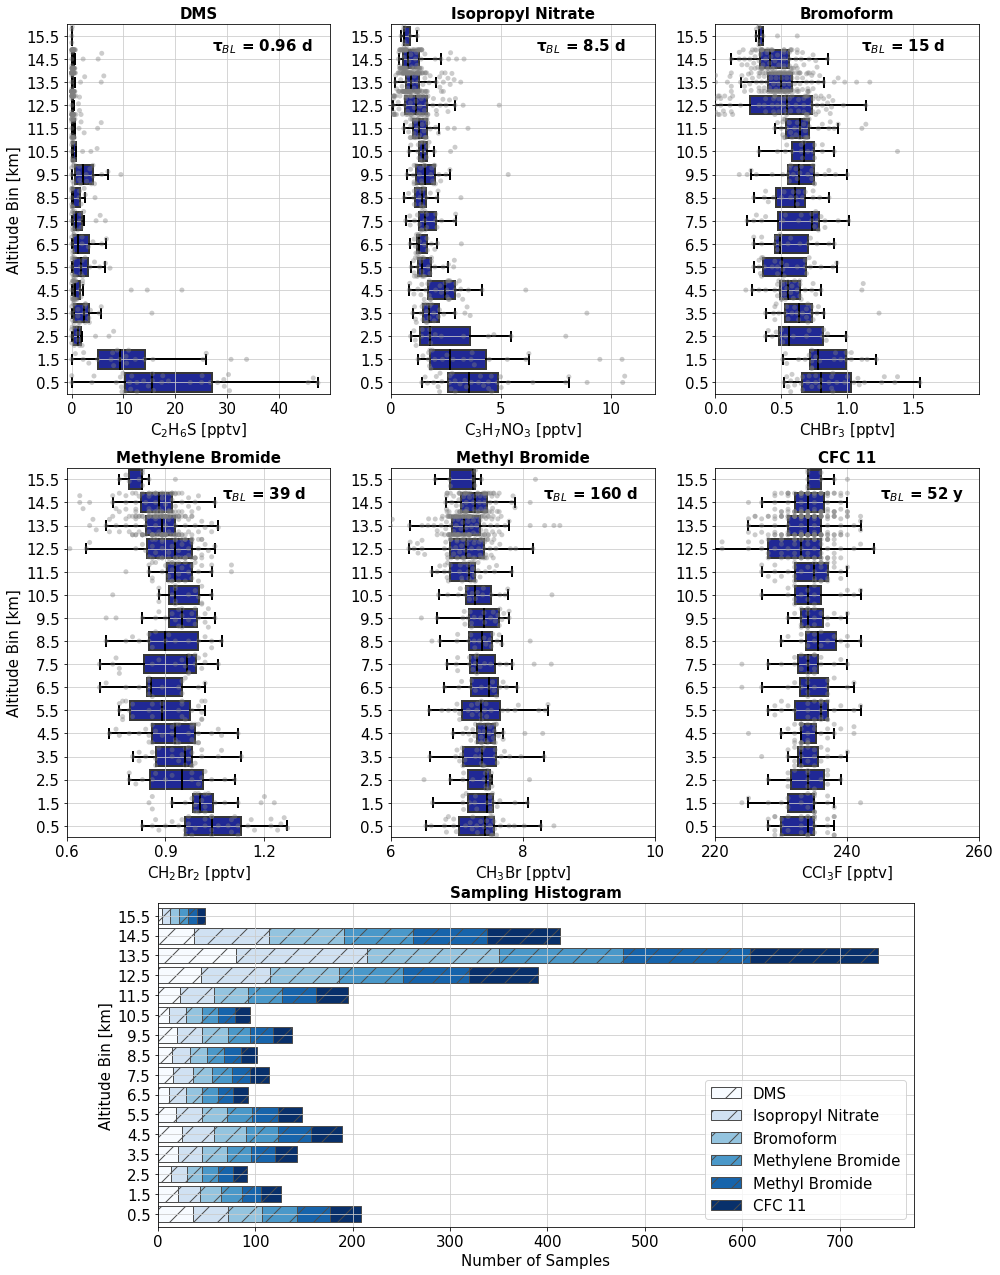

In [7]:
##### ----------------------------- make my axes to fill 
# https://matplotlib.org/gallery/subplots_axes_and_figures/gridspec_and_subplots.html
fig, axs = plt.subplots(figsize = (14,18), ncols=3, nrows=3)
gs = axs[2, 2].get_gridspec()

# remove the underlying axes
for ax in axs[2, -3:]:
    ax.remove()

##### ----------------------------- POPULATE PLOT 
#### C2H6S_Dimethyl_sulfide ------------------------------------------------------------------
# target axis 
axs[0, 0] = sns.boxplot(x = 'C2H6S_Dimethyl_sulfide', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[0, 0], order = np.flipud(alt_bin_labels))
axs[0, 0] = sns.swarmplot(x = 'C2H6S_Dimethyl_sulfide', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 0], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 0].lines, color = 'k')

# lifetime 
tau = awas_trc.C2H6S_Dimethyl_sulfide.BL_lifetime 
tau2 = round(tau, 2)
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 0].set_title('DMS', fontsize = 15, weight = 'bold') 
axs[0, 0].set_ylabel('Altitude Bin [km]', fontsize = 15) 

axs[0, 0].set_xlim([-1, 50])
axs[0, 0].set_xticks(np.arange(0, 50, step = 10))
axs[0, 0].set_xlabel(r'C$_2$H$_6$S [pptv]', fontsize=15)

axs[0, 0].tick_params(axis='both', which='major', labelsize=15)
axs[0, 0].grid(which='major', linestyle='-', color = '0.8')

axs[0, 0].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### C3H7NO3_Isopropyl_nitrate ------------------------------------------------------------------
# target axis 
axs[0, 1] = sns.boxplot(x = 'C3H7NO3_Isopropyl_nitrate', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[0, 1], order = np.flipud(alt_bin_labels))
axs[0, 1] = sns.swarmplot(x = 'C3H7NO3_Isopropyl_nitrate', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 1], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 1].lines, color = 'k')

# lifetime 
tau = awas_trc.C3H7NO3_Isopropyl_nitrate.BL_lifetime 
tau2 = round(tau, 1)
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 1].set_title('Isopropyl Nitrate', fontsize = 15, weight = 'bold') 
axs[0, 1].set_ylabel('') 

axs[0, 1].set_xlim([0, 12])
axs[0, 1].set_xticks(np.arange(0, 15, step = 5))
axs[0, 1].set_xlabel(r'C$_3$H$_7$NO$_3$ [pptv]', fontsize=15)

axs[0, 1].tick_params(axis='both', which='major', labelsize=15)
axs[0, 1].grid(which='major', linestyle='-', color = '0.8')

axs[0, 1].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### CHBr3_Bromoform ------------------------------------------------------------------
# target axis 
axs[0, 2] = sns.boxplot(x = 'CHBr3_Bromoform', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[0, 2], order = np.flipud(alt_bin_labels))
axs[0, 2] = sns.swarmplot(x = 'CHBr3_Bromoform', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 2], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 2].lines, color = 'k')

# lifetime 
tau = awas_trc.CHBr3_Bromoform.BL_lifetime 
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 2].set_title('Bromoform', fontsize = 15, weight = 'bold') 
axs[0, 2].set_ylabel('') 

axs[0, 2].set_xlim([0, 2])
axs[0, 2].set_xticks(np.arange(0, 2, step = 0.5))
axs[0, 2].set_xlabel(r'CHBr$_3$ [pptv]', fontsize=15)

axs[0, 2].tick_params(axis='both', which='major', labelsize=15)
axs[0, 2].grid(which='major', linestyle='-', color = '0.8')

axs[0, 2].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### CH2Br2_Methylene_bromide ------------------------------------------------------------------
# target axis 
axs[1, 0] = sns.boxplot(x = 'CH2Br2_Methylene_bromide', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[1, 0], order = np.flipud(alt_bin_labels))
axs[1, 0] = sns.swarmplot(x = 'CH2Br2_Methylene_bromide', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 0], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 0].lines, color = 'k')

# lifetime 
tau = awas_trc.CH2Br2_Methylene_bromide.BL_lifetime 
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[1, 0].set_title('Methylene Bromide', fontsize = 15, weight = 'bold') 
axs[1, 0].set_ylabel('Altitude Bin [km]', fontsize = 15) 

axs[1, 0].set_xlim([0.6, 1.4])
axs[1, 0].set_xticks(np.arange(0.6, 1.5, step = 0.3))
axs[1, 0].set_xlabel(r'CH$_2$Br$_2$ [pptv]', fontsize=15)

axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 0].grid(which='major', linestyle='-', color = '0.8')

axs[1, 0].annotate(tau_str, (1.07, 14.5), xytext=(1.07, 0.83), fontsize = 15, weight='bold')

#### CH3Br_Methyl_bromide ------------------------------------------------------------------
# target axis 
axs[1, 1] = sns.boxplot(x = 'CH3Br_Methyl_bromide', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[1, 1], order = np.flipud(alt_bin_labels))
axs[1, 1] = sns.swarmplot(x = 'CH3Br_Methyl_bromide', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 1], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 1].lines, color = 'k')

# lifetime 
tau = awas_trc.CH3Br_Methyl_bromide.BL_lifetime 
tau2 = int(round(tau, -1))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[1, 1].set_title('Methyl Bromide', fontsize = 15, weight = 'bold') 
axs[1, 1].set_ylabel('') 

axs[1, 1].set_xlim([6, 10])
axs[1, 1].set_xticks(np.arange(6, 12, step = 2))
axs[1, 1].set_xlabel(r'CH$_3$Br [pptv]', fontsize=15)

axs[1, 1].tick_params(axis='both', which='major', labelsize=15)
axs[1, 1].grid(which='major', linestyle='-', color = '0.8')

axs[1, 1].annotate(tau_str, (8.1, 14.5), xytext=(8.3, 0.81), fontsize = 15, weight='bold')

#### CCl3F_CFC_11 ------------------------------------------------------------------
# target axis 
axs[1, 2] = sns.boxplot(x = 'CCl3F_CFC_11', y = 'alt_bins', data = awas_df, linewidth = 2, whis = 1.5, 
                        color = color_awas, showfliers = False, ax = axs[1, 2], order = np.flipud(alt_bin_labels))
axs[1, 2] = sns.swarmplot(x = 'CCl3F_CFC_11', y = 'alt_bins', data = awas_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 2], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 2].lines, color = 'k')

# lifetime 
tau = (awas_trc.CCl3F_CFC_11.BL_lifetime)/365
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' y'

# axes, labels, ticks, .... 
axs[1, 2].set_title('CFC 11', fontsize = 15, weight = 'bold') 
axs[1, 2].set_ylabel('') 

axs[1, 2].set_xlim([220, 260])
axs[1, 2].set_xticks(np.arange(220, 280, step = 20))
axs[1, 2].set_xlabel(r'CCl$_3$F [pptv]', fontsize=15)

axs[1, 2].tick_params(axis='both', which='major', labelsize=15)
axs[1, 2].grid(which='major', linestyle='-', color = '0.8')

axs[1, 2].annotate(tau_str, (245, 14.5), xytext=(245, 0.83), fontsize = 15, weight='bold')

# squeeeeeeeze
fig.tight_layout()

##### ----------------------------- ADD BIG PLOT AT BOTTOM
# add bigger one in its place 
#axbig = fig.add_subplot(gs[2, -3:])
axbig = fig.add_axes([0.16, 0.05, 0.75, 0.25])

axbig.set_title('Sampling Histogram', fontsize = 15, weight = 'bold') 
awas_df_count_forplot.plot(kind='barh', stacked=True, colormap='Blues',  
                           hatch='/', width = 0.8, ax = axbig, fontsize = 15, edgecolor='0.3')
axbig.set_ylabel('Altitude Bin [km]', fontsize = 15) 
axbig.set_xlabel('Number of Samples', fontsize = 15) 
axbig.grid(which='major', linestyle='-', color = '0.8')
axbig.legend(fontsize = 15)

##### ----------------------------- save
fig.savefig('awas_vertical_profiles.svg', format='svg', dpi=1200)
fig.savefig('awas_vertical_profiles.pdf')  